In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data preparation

In [2]:
data_train = np.load('CompleteDataSet_training_tuples/CompleteDataSet_training_tuples.npy',allow_pickle=True)
data_test = np.load('CompleteDataSet_testing_tuples/CompleteDataSet_testing_tuples.npy',allow_pickle=True)
data_validation = np.load('CompleteDataSet_validation_tuples/CompleteDataSet_validation_tuples.npy',allow_pickle=True)

In [3]:
data_train.shape, data_test.shape, data_validation.shape

((200331, 2), (66778, 2), (66777, 2))

In [4]:
#All unique labels
np.unique(data_train[:,1])

array(['%', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '[', ']'], dtype=object)

In [5]:
X_train = data_train[:,0]
y_train = data_train[:,1]

X_test = data_test[:,0]
y_test = data_test[:,1]

X_validation = data_validation[:,0]
y_validation = data_validation[:,1]

#'%' is actually '/', so we change the label
y_train = np.where(y_train!='%',y_train,'/')
y_test = np.where(y_test!='%',y_test,'/')
y_validation = np.where(y_validation!='%',y_validation,'/')

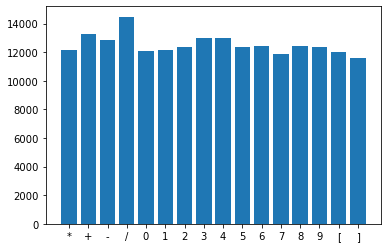

In [6]:
unique, indices, counts = np.unique(y_train, return_index=True ,return_counts=True)
fig, ax = plt.subplots()
ax.bar(unique,counts)
plt.show()

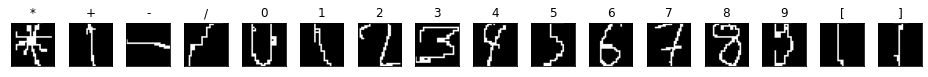

In [7]:
characters = X_train[indices]
plt.figure(figsize=(13, 2))
for i in range(len(characters)):
    plt.subplot(1, len(characters), i + 1)
    plt.imshow(characters[i], cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title(y_train[indices][i])
plt.tight_layout()

In [8]:
X_train = np.stack(X_train, axis=0)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))

X_test = np.stack(X_test, axis=0)
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

X_validation = np.stack(X_validation, axis=0)
X_validation = X_validation.reshape((X_validation.shape[0], 28, 28, 1))

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values
y_validation = pd.get_dummies(y_validation).values

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

## Creating CNN model

In [9]:
def create_model(learning_rate):
    model=Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(unique.shape[0], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [10]:
def train_model(model, X_train, y_train, epochs, batch_size, X_validation, y_validation):
    callback = EarlyStopping(monitor='val_loss', mode='min', patience = 2)
    history=model.fit(X_train, y_train, batch_size=batch_size,
                      epochs=epochs, callbacks=[callback], 
                      validation_data=(X_validation, y_validation))
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [11]:
def plot_metrics(epochs, hist, metrics, title):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(title)

    for m in metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

In [12]:
learning_rate=0.001
epochs=15
batch_size=128

Train on 200331 samples, validate on 66777 samples
Epoch 1/15
200331/200331 [==============================] - 129s 646us/sample - loss: 0.3958 - accuracy: 0.8751 - val_loss: 0.1469 - val_accuracy: 0.9526
Epoch 2/15
200331/200331 [==============================] - 117s 584us/sample - loss: 0.1865 - accuracy: 0.9396 - val_loss: 0.1142 - val_accuracy: 0.9621
Epoch 3/15
200331/200331 [==============================] - 120s 597us/sample - loss: 0.1486 - accuracy: 0.9513 - val_loss: 0.0978 - val_accuracy: 0.9671486 - ac
Epoch 4/15
200331/200331 [==============================] - 118s 589us/sample - loss: 0.1293 - accuracy: 0.9568 - val_loss: 0.0826 - val_accuracy: 0.9714
Epoch 5/15
200331/200331 [==============================] - 116s 580us/sample - loss: 0.1147 - accuracy: 0.9605 - val_loss: 0.0753 - val_accuracy: 0.9739
Epoch 6/15
200331/200331 [==============================] - 115s 574us/sample - loss: 0.1051 - accuracy: 0.9637 - val_loss: 0.0696 - val_accuracy: 0.9755
Epoch 7/15
200331

[0.055744979145982886, 0.9804277]

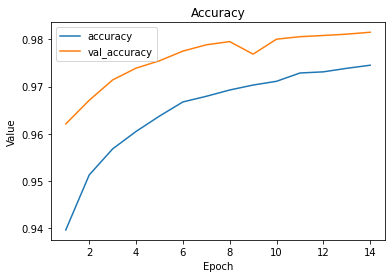

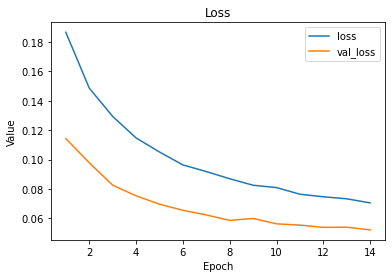

In [13]:
model=create_model(learning_rate)
epochs, hist = train_model(model, X_train, y_train, 
                           epochs, batch_size, X_validation, y_validation)
plot_metrics(epochs, hist, ['accuracy','val_accuracy'], "Accuracy")
plot_metrics(epochs, hist, ['loss','val_loss'], "Loss")
model.evaluate(x = X_test, y = y_test, batch_size=batch_size, verbose=0)

## Saving model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [15]:
model.save('models/model_2.h5')

## Predictions

In [16]:
#We code symbols with numbers
codes={i:unique[i] for i in range(len(unique))}
codes

{0: '*',
 1: '+',
 2: '-',
 3: '/',
 4: '0',
 5: '1',
 6: '2',
 7: '3',
 8: '4',
 9: '5',
 10: '6',
 11: '7',
 12: '8',
 13: '9',
 14: '[',
 15: ']'}

In [17]:
#Saving codes
with open("codes", "wb") as fp:   #Pickling
    pickle.dump(codes, fp)

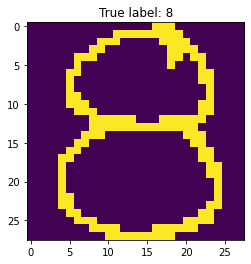

In [18]:
plt.imshow(X_test[7])
#label
plt.title(f'True label: {codes[np.argmax(y_test[7])]}')
plt.show()

In [19]:
prediction = model.predict(X_test[np.newaxis,7])
print(f'Model prediction is {codes[np.argmax(prediction)]}')

Model prediction is 8
